# Data Preparation
- Prepare dataset in order to fit the requirements and assumptions for the return forecasting
---
- We also need to prepare dataset so it will fit the trading strategy 
#### Takeaway:
- Need to create return (independent variable for making forecasts) and SMA (2) variables for trading strategy implementation 

### 1. Import libraries and download dataset

In [1]:
# Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import itertools


In [2]:
# Read parquet df
raw_data = pd.read_parquet('raw_data.parquet', engine='pyarrow')

### 2. Functions
- Set functions for Data cleaning, edition, adding columns, plotting

In [3]:
# Add return column
def calculate_variables(data, short_SMA, long_SMA):
    # Add return column
    #return_column = data.close - data.close.shift(1)
    #data.insert(loc=0, column='return', value=return_column)
    # Add date column
    date_column = data['time'].dt.date
    data.insert(loc=1, column='date', value=date_column)
    # Add columns for SMA strategy
    data['short_SMA'] = ta.sma(data['close'],short_SMA)
    data['long_SMA'] = ta.sma(data['close'],long_SMA)
    
    # Delete rows with NaN values for SMA columns 
    cleaned_data = data.dropna().reset_index(drop=True)
    
    return cleaned_data

In [4]:
#Detect buy and sell signals
def buy_sell_signals(data):
    # Empty lists for signals
    signalBuy = []
    signalSell = []
    position = False 
    # Append time lag to BUY signal list if short SMA is higher than long SMA, in otheer case append time lag to SELL signal list
    for i in range(len(data)):
        if data['short_SMA'][i] > data['long_SMA'][i]:
            if position == False :
                signalBuy.append(data['close'][i])
                signalSell.append(np.nan)
                position = True
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        elif data['short_SMA'][i] < data['long_SMA'][i]:
            if position == True:
                signalBuy.append(np.nan)
                signalSell.append(data['close'][i])
                position = False
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        else:
            signalBuy.append(np.nan)
            signalSell.append(np.nan)
    return pd.Series([signalBuy, signalSell])

In [5]:
# Prepare data for SMA strategy
def final_data(data, short_SMA, long_SMA, start_date, end_date):
    # Add SMA columns
    cleaned_data = calculate_variables(data, short_SMA, long_SMA)
   
    # Add columns for BUY/SELL signals
    cleaned_data['Buy_Signal_price'], cleaned_data['Sell_Signal_price'] = buy_sell_signals(cleaned_data)
    # Filter data by date
    cleaned_data = cleaned_data.loc[(cleaned_data['date'] >= pd.to_datetime(start_date).date()) & (cleaned_data['date'] <= pd.to_datetime(end_date).date())]
    
    
    return cleaned_data

In [6]:
# Plot with of closing prices with BUY/SELL signals marked
def plot_SMA(data, short_SMA, long_SMA, start_date, end_date):  # both dates need to be entered in a yyyy-mm-dd format

    # Plot
    fig, ax = plt.subplots(figsize=(26,12))
    ax.plot(data['time'], data['close'], label = 'BTC/BUSD' ,linewidth=1 ,color='blue', alpha = 0.9)
    ax.plot(data['time'], data['short_SMA'], label = f'SMA{short_SMA}', linewidth=1, alpha = 0.85)
    ax.plot(data['time'], data['long_SMA'], label = f'SMA{long_SMA}', linewidth=1,  alpha = 0.85)
    ax.scatter(data['time'], data['Buy_Signal_price'] , label = 'Buy' , marker = '^', color = 'green', alpha=1, linewidths=5)
    ax.scatter(data['time'], data['Sell_Signal_price'] , label = 'Sell' , marker = 'v', color = 'red', alpha=1, linewidths=5)
    ax.set_title(f'BTC/BUSD - Price History with buy and sell signals ({start_date} - {end_date})',fontsize=20)
    ax.set_xlabel('Time' ,fontsize=18)
    ax.set_ylabel('Close Price INR (₨)' , fontsize=18)
    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()

In [7]:

# Calculate basic statistics for the return on investment, differences in BUY/SELL prices
def difference_statistics(data):
    # Extract BUY/SELL signals column from the final dataset
    signal_data = data.loc[:,['Buy_Signal_price', 'Sell_Signal_price']] 
    signal_data = signal_data.dropna(axis = 0, how = 'all')  # Filter data so to obtain only with time lag when the signal has been generated
    signal_data = signal_data.reset_index(drop=True)  # Reset index
    # List of signal prices
    buy_signals = signal_data.loc[:, 'Buy_Signal_price'].tolist()
    sell_signals = signal_data.loc[:, 'Sell_Signal_price'].tolist()
     # Filter nan values off the signal lists 
    buy_signals = [b_signal for b_signal in buy_signals if str(b_signal) != 'nan']
    sell_signals = [s_signal for s_signal in sell_signals if str(s_signal) != 'nan']
    
    
    return buy_signals, sell_signals
    
    # Print basic statistics
    #print(f'BUY signals number: {len(buy_signals)}')
    #print(f'SELL signals number: {len(sell_signals)}')
    #print(f'Average BUY price: {sum(buy_signals) / len(buy_signals)}')
    #print(f'Average SELL price: {sum(sell_signals) / len(sell_signals)}')
    #print(f'TOTAL difference in prices: {sum(sell_signals) - sum(buy_signals)}')


### 3. Analysis
- The goal is to find the most optimal values for the short and long SMA in order to maximize the in plus difference for preceding BUY/SELL  signal pairs 
https://www.investopedia.com/articles/active-trading/010116/perfect-moving-averages-day-trading.asp
---
- We will start with the combination of 5 time lags for short SMA and 13 time lags for long SMA (as in the article attached above), later on possible implementation of gridsearch for both SMA length optimization

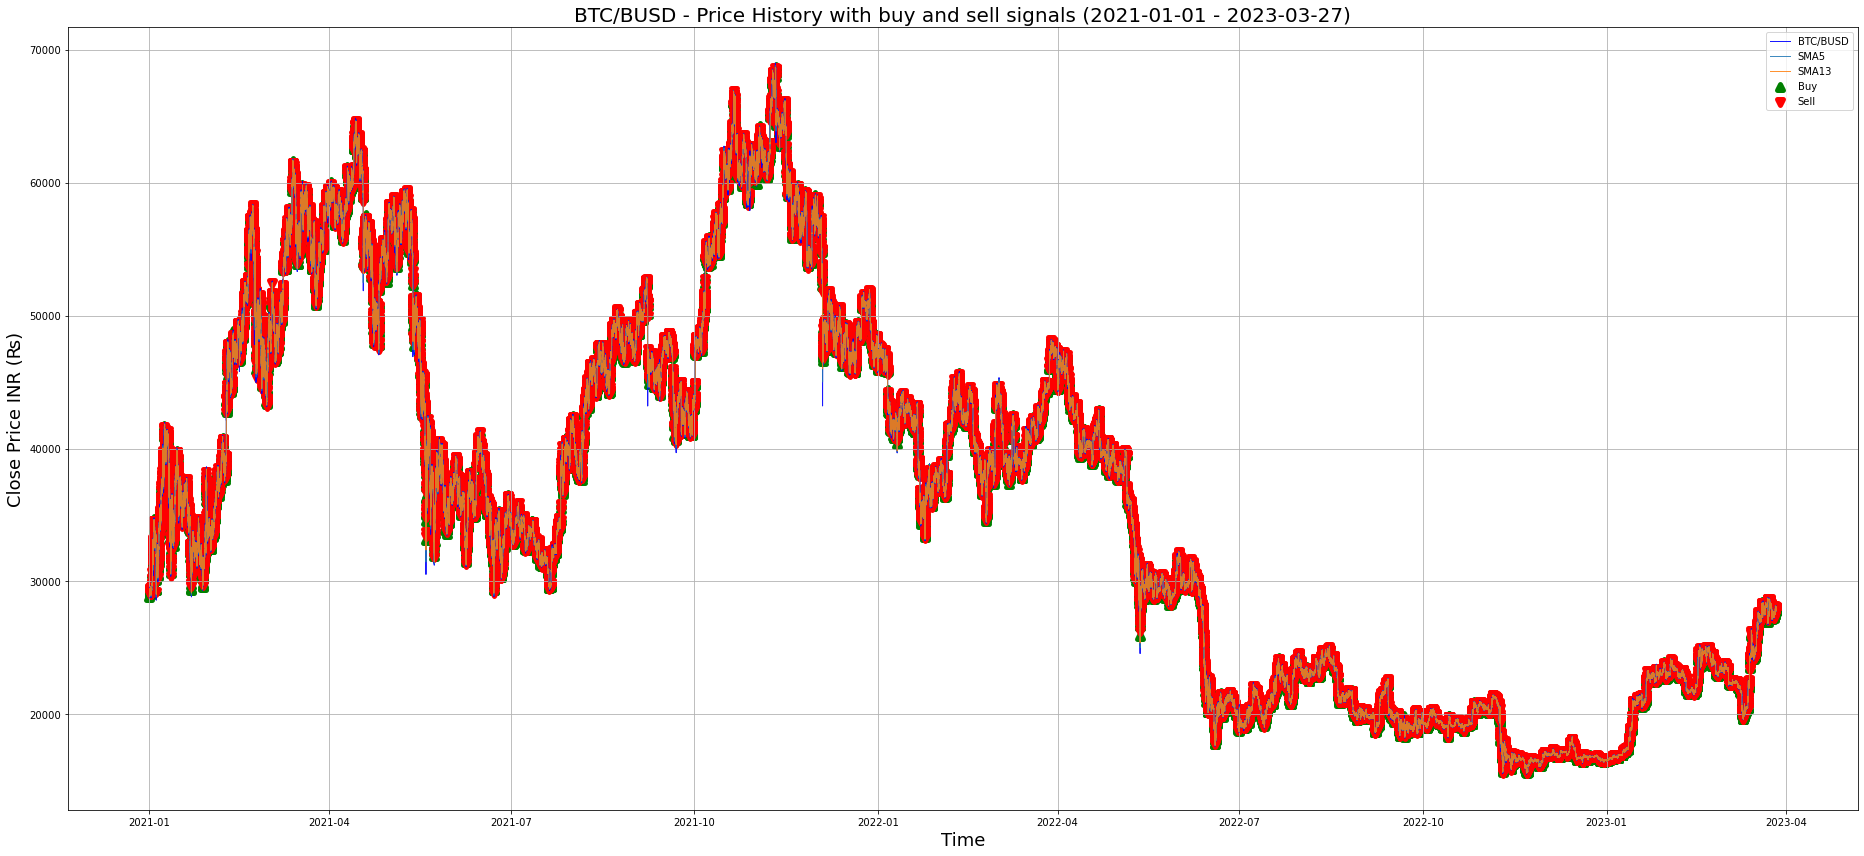

In [29]:
# Plot the signals and SMAs for the full period

# Create a temporary copy of raw dataset
copy = raw_data.copy()
# Filter only columns needed for further analysis
copy = copy.loc[:,['time', 'close']]

# SMAs lengths
short_SMA = 5
long_SMA = 13
# Dates for studied period
start_date = '2021-01-01'
end_date = '2023-03-27'
# Preprocess raw data
final_df = final_data(copy, short_SMA, long_SMA, start_date, end_date)
# Plot signals and SMAs
plot_SMA(final_df, short_SMA, long_SMA, start_date, end_date)


#### Takeaway:
- By just looking at the plot we can see that it consists of a couple of middle-ranged trends (both increasing and decresing), overall trend is decreseing
---
- As we are studying the 1m interval data, we need to focus on shorter perspective, we need to take a closer look at the shorter periods
---
- Need to determine when the strategy works and point out when it doesnt, that way we will be able to better develop the forecasting model

In [31]:
final_df

,time,date,close,short_SMA,long_SMA,Buy_Signal_price,Sell_Signal_price
0,2021-01-01 00:12:00,2021-01-01,28884.19,28897.766,28964.592308,NaN,NaN
1,2021-01-01 00:13:00,2021-01-01,28760.27,28861.230,28946.320000,NaN,NaN
2,2021-01-01 00:14:00,2021-01-01,28792.88,28839.620,28926.657692,NaN,NaN
3,2021-01-01 00:15:00,2021-01-01,28812.12,28823.448,28910.043077,NaN,NaN
4,2021-01-01 00:16:00,2021-01-01,28854.65,28820.822,28897.152308,NaN,NaN
...,...,...,...,...,...,...,...
1172511,2023-03-26 23:56:00,2023-03-26,27985.00,28003.792,28023.901538,NaN,NaN
1172512,2023-03-26 23:57:00,2023-03-26,27998.28,28001.158,28020.658462,NaN,NaN
1172513,2023-03-26 23:58:00,2023-03-26,27998.27,27997.892,28016.326923,NaN,NaN
1172514,2023-03-26 23:59:00,2023-03-26,27998.35,27994.930,28011.183077,NaN,NaN


In [32]:
# Calculate basic statistics for the return on investment

# Create a temporary copy of final (with signals) dataset
copy = final_df.copy()
# Filter only columns needed for further analysis
copy = copy.loc[:,['Buy_Signal_price', 'Sell_Signal_price']]
# Instantiate signals variables
buy_signals, sell_signals = difference_statistics(copy)
# Print statistics
print(f'BUY signals number: {len(buy_signals)}')
print(f'SELL signals number: {len(sell_signals)}')
print(f'Average BUY price: {sum(buy_signals) / len(buy_signals)}')
print(f'Average SELL price: {sum(sell_signals) / len(sell_signals)}')
print(f'TOTAL difference in prices: {sum(sell_signals) - sum(buy_signals)}')

BUY signals number: 52782
SELL signals number: 52782
Average BUY price: 36125.861712136415
Average SELL price: 36124.45414099472
TOTAL difference in prices: -74294.42000102997


#### Takeaway:
- At the first glance obtained statistics show inefficiency in the planned strategy
---
- Average BUY price is only slightly lower than average SELL price, but when we aggregate all prices for the 52782 actions, the difference is almost 75k in minus
---
- This means it is needed to verify when the planned strategy works well and when not 

In [33]:
# Check for negative and positive return days

# Create a temporary copy of final (with signals) dataset
copy = final_df.copy()
# Narrow data for analysis
narrowed_columns_df = copy.loc[:, ['date', 'time', 'close', 'short_SMA', 'long_SMA', 'Buy_Signal_price', 'Sell_Signal_price']]
# Aggregate sum by date
grouped_date_df = narrowed_columns_df.iloc[:,[0,-2,-1]].groupby('date').sum()
# Create column for difference between SELL and BUY signal prices
grouped_date_df['signal_difference'] = grouped_date_df['Sell_Signal_price'] - grouped_date_df['Buy_Signal_price']
# Filter dataframe only for days when the difference is negative
filtered_negatives = grouped_date_df[grouped_date_df['signal_difference'] < 0]
# Filter dataframe only for days when the difference is positive
filtered_positives = grouped_date_df[grouped_date_df['signal_difference'] > 0]
# Make a list of negative return days
negative_return_list = filtered_negatives.index.tolist()

In [34]:
print(f'Overall number of days: {len(grouped_date_df)}')
print(f'Number of days with negative return: {len(negative_return_list)}')

Overall number of days: 816
Number of days with negative return: 463


#### Takeaway:
- Out of 816 days, 463 have negative difference between SELL and BUY actions
---
- Its a bit too much days to look closer, lets narrow them down by highest negative difference days or get even to hours

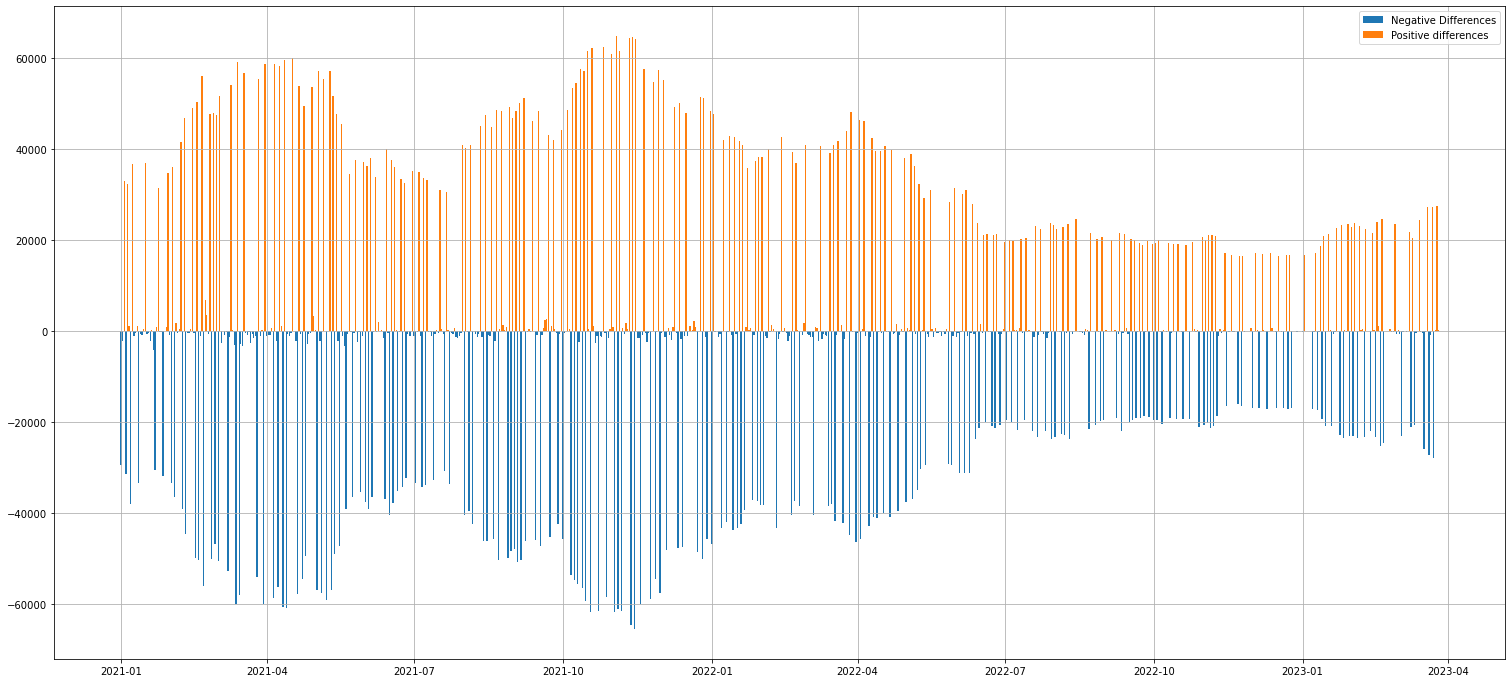

In [35]:
# Check for distribution of negative returns
fig, ax = plt.subplots(figsize=(26,12))
ax.bar(filtered_negatives.index, filtered_negatives['signal_difference'], label='Negative Differences')
ax.bar(filtered_positives.index, filtered_positives['signal_difference'], label='Positive differences')
ax.legend()
ax.grid()

#### Takeaway:
- From the plot above looks that it does not really matter what is the middle ranged trend, negative differences are distributed relatively evenly
---
- Lets first norrow it down to highest loosing days

In [36]:
# Filter days with the biggest losses
filtered_negatives.nsmallest(10, 'signal_difference')

,Buy_Signal_price,Sell_Signal_price,signal_difference
date,,,
2021-11-14,4125656.96,4060219.33,-65437.63
2021-11-12,4303237.20,4238693.90,-64543.30
2021-11-02,3754665.57,3692956.64,-61708.93
2021-10-18,3766964.92,3705397.45,-61567.47
2021-10-23,3666128.09,3604691.79,-61436.30
2021-11-06,3780859.41,3719509.48,-61349.93
2021-11-04,3897826.42,3836914.20,-60912.22
2021-04-13,4037630.21,3976819.49,-60810.72
2021-04-11,3944703.03,3884043.23,-60659.80


### 4. GridSearch

- One of the posssible approches is to calculate aggregated returns on different combinations of lengths for short and long SMAs
---
- The main goal is to be able to participate efficiently in a high frequency trading market, therefore we need to assume constraints for the length of both SMAs
---
- We assume the lenghth of range between 2 and 15 for short SMA and rnge from 8 to 60 for long SMA, that way we narrow down the options that need to be considered in a similuation and keep the high frequency characteristics of potential actions

In [43]:
# Create lists with ranges of SMAs values for combinations calculation

# Short SMA list
short_SMA_list = list(range(2,16))
# Long SMA list
long_SMA_list = list(range(8,61))
# Calculate all of the combinations
combinations = list(itertools.product(short_SMA_list, long_SMA_list))

In [44]:
len(combinations)

742

In [64]:
# Create dataframe for results gathering
results_df = pd.DataFrame(columns=['short_SMA', 'long_SMA', 'signal_difference'])
# Dates for studied period
start_date = '2021-01-01'
end_date = '2023-03-27'
# Loop over combinations of SMAs lenghts
for combination in combinations:
    # Create a temporary copy of raw dataset
    copy = raw_data.copy()
    # Filter only columns needed for further analysis
    copy = copy.loc[:,['time', 'close']]
    # Preprocess raw data
    final_test_df = final_data(copy, combination[0], combination[1], start_date, end_date)
    buy_sig, sell_sig = difference_statistics(final_test_df)
    signal_diff = sum(sell_sig) - sum(buy_sig)
    
    result = pd.DataFrame({
        'short_SMA': [combination[0]],
        'long_SMA': [combination[1]],
        'signal_difference': [signal_diff]
                            }, index=[len(results_df)])
    
    results_df = results_df.append(result)
    #print(len(results_df))
    print(results_df)

  short_SMA long_SMA  signal_difference
0         2        8       28172.830157
  short_SMA long_SMA  signal_difference
0         2        8       28172.830157
1         2        9       33793.470115
  short_SMA long_SMA  signal_difference
0         2        8       28172.830157
1         2        9       33793.470115
2         2       10        6530.130076
  short_SMA long_SMA  signal_difference
0         2        8       28172.830157
1         2        9       33793.470115
2         2       10        6530.130076
3         2       11        3858.120027
  short_SMA long_SMA  signal_difference
0         2        8       28172.830157
1         2        9       33793.470115
2         2       10        6530.130076
3         2       11        3858.120027
4         2       12        1960.569994
  short_SMA long_SMA  signal_difference
0         2        8       28172.830157
1         2        9       33793.470115
2         2       10        6530.130076
3         2       11        3858.120027


In [61]:
# Find out the combinations with the largest return
#results_df = results_df.nsmallest(50, 'signal_difference')
#results_df = results_df[results_df['short_SMA'] < results_df['long_SMA']]
#results_df

In [68]:
# Highest return 
results_df.nlargest(50, 'signal_difference')[results_df['short_SMA'] < results_df['long_SMA']]

<ipython-input-68-bdf98ef8626e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df.nlargest(50, 'signal_difference')[results_df['short_SMA'] < results_df['long_SMA']]


,short_SMA,long_SMA,signal_difference
1,2,9,33793.470115
0,2,8,28172.830157
53,3,8,27564.690055
54,3,9,15893.700005
698,15,17,11856.389997
106,4,8,10537.680025
8,2,16,7229.210010
2,2,10,6530.130076
3,2,11,3858.120027
5,2,13,3655.529984


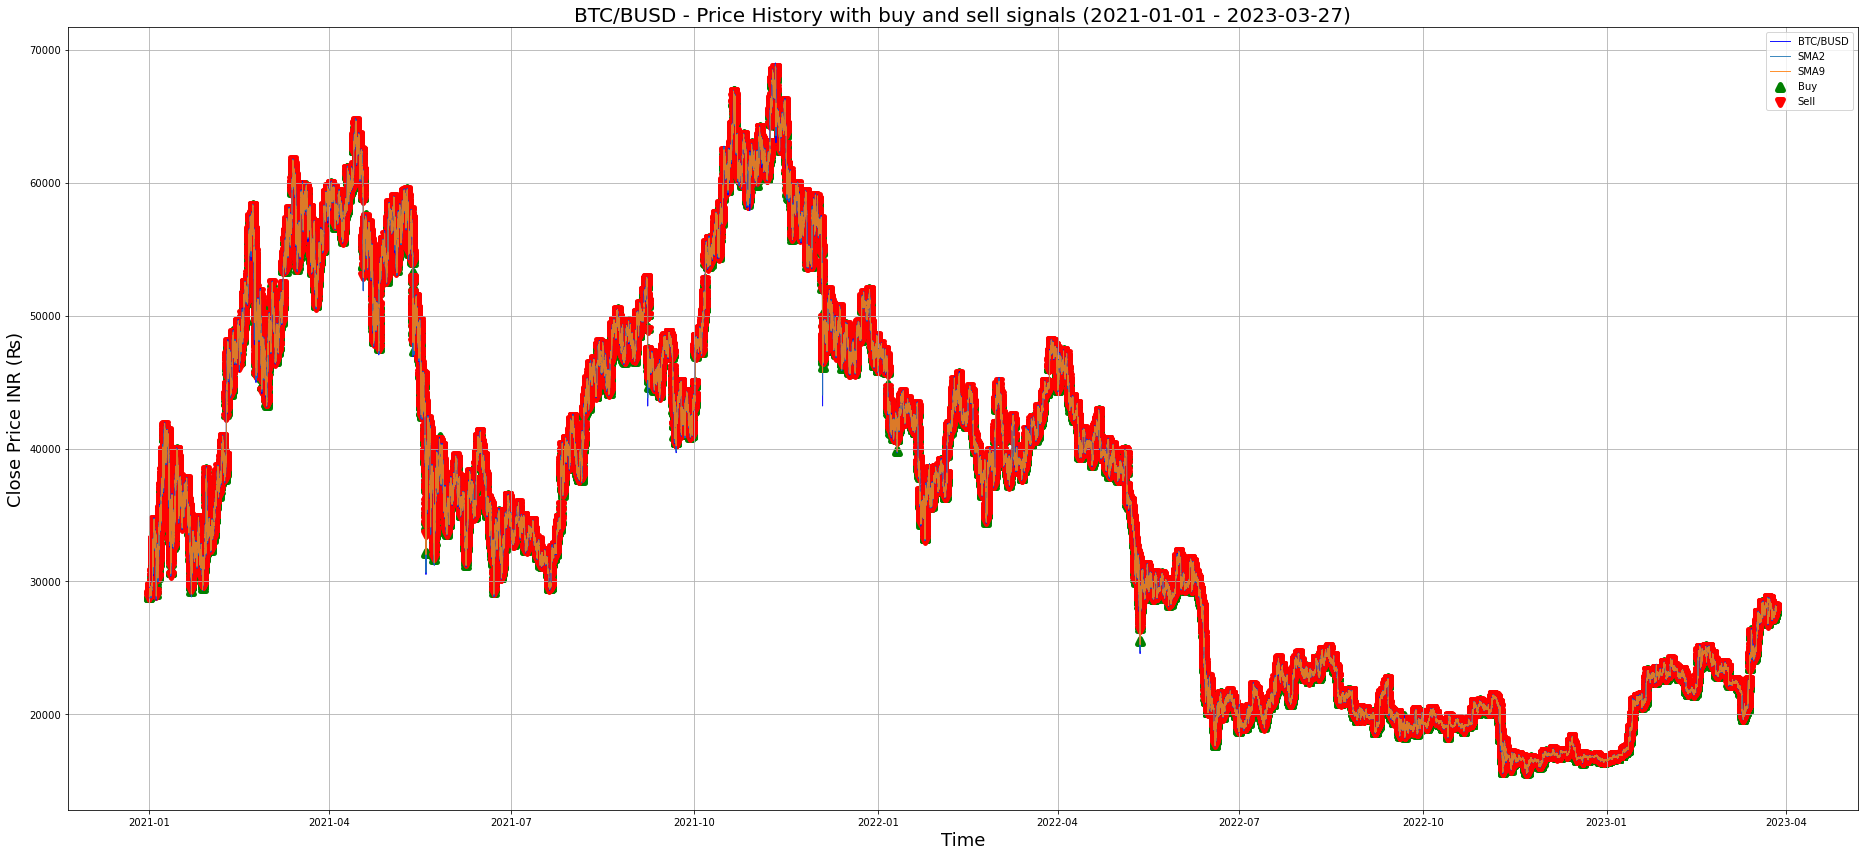

BUY signals number: 86863
SELL signals number: 86863
Average BUY price: 36037.87672760457
Average SELL price: 36038.265770926984
TOTAL difference in prices: 33793.470115184784


In [63]:
# Plot the signals and SMAs for the full period

# Create a temporary copy of raw dataset
copy = raw_data.copy()
# Filter only columns needed for further analysis
copy = copy.loc[:,['time', 'close']]

# SMAs lengths
short_SMA = 2
long_SMA = 9
# Dates for studied period
start_date = '2021-01-01'
end_date = '2023-03-27'
# Preprocess raw data
final_df = final_data(copy, short_SMA, long_SMA, start_date, end_date)
# Plot signals and SMAs
plot_SMA(final_df, short_SMA, long_SMA, start_date, end_date)

# Calculate basic statistics for the return on investment

# Create a temporary copy of final (with signals) dataset
copy = final_df.copy()
# Filter only columns needed for further analysis
copy = copy.loc[:,['Buy_Signal_price', 'Sell_Signal_price']]
# Instantiate signals variables
buy_signals, sell_signals = difference_statistics(copy)
# Print statistics
print(f'BUY signals number: {len(buy_signals)}')
print(f'SELL signals number: {len(sell_signals)}')
print(f'Average BUY price: {sum(buy_signals) / len(buy_signals)}')
print(f'Average SELL price: {sum(sell_signals) / len(sell_signals)}')
print(f'TOTAL difference in prices: {sum(sell_signals) - sum(buy_signals)}')